## Тут просто ручная реализация логистической регрессии с сигмоидой и регуляризацией на датасете Titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def prepare_dataset(df):
    df = df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
    df['Sex'] = (train_data['Sex'] == 'male').astype(np.int) * 2 - 1
    df = df.fillna({'Age': df['Age'].mean()})
    df['Age'] /= 100
    df['Fare'] /= 100
    df['_bias'] = 1
    if 'Survived' in df.columns:
        return df.drop(['Survived'], axis=1), (df['Survived'] * 2 - 1)
    else:
        return df

In [3]:
train_data = pd.read_csv('titanic-dataset/train.csv')
train_features, train_answers = prepare_dataset(train_data)

In [4]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', '_bias']
X = train_features[features].to_numpy()
y = train_answers.to_numpy()

100%|██████████| 10000/10000 [00:02<00:00, 3631.70it/s]


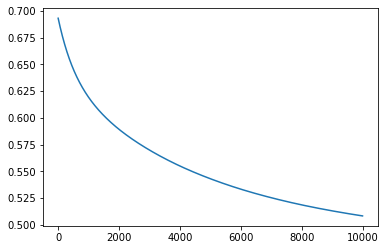

In [5]:
from tqdm import tqdm
iterations = 10000
alpha = 5e-4
tau = 1e-4

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

w = np.zeros((X.shape[1]))
errors = []
best_w = w
best_err = None
for it in tqdm(range(iterations)):
    errors.append(tau / 2 * np.sum(w**2) +
                  -np.mean(np.log( sigmoid(y * (X @ w)) ) )
                 )
    if best_err is None or errors[-1] < best_err:
        best_w = w
        best_err = errors[-1]
    w -= alpha * (-np.array([
        np.dot(y * sigmoid(- y * (X @ w)), X[:, j])
        for j in range(X.shape[1])
    ]) / X.shape[0] + tau * w)
    if it % 2000 == 0: alpha *= 0.99

plt.plot([i for i in range(len(errors))], errors)

In [6]:
print(best_err, dict(zip(features, best_w)))

0.5083628590243644 {'Pclass': -0.25448221014982475, 'Sex': -0.7259809907909153, 'Age': -0.002754196717751497, 'SibSp': -0.06649224548174588, 'Parch': 0.07284822343355604, 'Fare': 0.2028887945428732, '_bias': 0.07663128918250531}


In [7]:
train_predictions = (sigmoid(X @ w) >= 0.5).astype(np.int) * 2 - 1
print('Score: {}'.format( np.mean( train_predictions == y ) ))

Score: 0.8024691358024691


## Инфраструктура для консенсуса

Как происходит коммуникация: каждый агент получает на каждого соседа пару (read, write) asyncio очередей для общения.
Аналогично с мастер-нодой консенсуса.

Протокол консенсуса в данный момент такой:
1. Мастер-нода получает топологию и агентов;
2. Мастер-нода устанавливает связь между собой и агентами (передает сокеты);
3. Мастер-нода передает сокеты для общения между агентами;
4. Мастер передает всем агентам NETWORK_READY;
4. Агенты заявляют о готовности начать новый раунд консенсуса (отправляют NEW_ROUND мастеру);
5. Когда все агенты готовы, мастер посылает всем NEW_ROUND --- начинается новый раунд консенсуса;
6. Агенты вычисляют функцию;
7. Агенты запрашивают у соседей значение их функции (отправка REQUEST_VALUE) и получают от соседей посчитанное значение;
8. Когда агент понимает, что он сошелся с соседями, он посылает мастеру CONVERGED (но при этом агент все еще должен участвовать в коммуникации с соседями);
9. Если агент понял, что сходимость не достигнута, то он может отменить CONVERGED отправкой NOT_CONVERGED;
10. Когда все агенты заявили о том, что значение сошлось, мастер посылает всем DONE;
11. jmp 5

In [8]:
topology_pair = [(0, 1)]
topology_cycle_3 = [(0, 1), (1, 2), (2, 0)] 
topology_grid_5 = [('center', 'west'), ('center', 'east'), ('center', 'north'), ('center', 'south'),
                   ('west', 'north'), ('north', 'east'), ('east', 'south'), ('west', 'south')]
'''
     @
    /|\
   @-@-@  topology_grid_5
    \|/
     @
'''
import numpy as np
from threading import Thread, Lock, RLock
import asyncio, sys

# asyncio.get_event_loop().set_debug(True)

NEW_ROUND = 'NEW_ROUND'
REQUEST_VALUE = 'REQUEST_VALUE'
CONVERGED = 'CONVERGED'
NOT_CONVERGED = 'NOT CONVERGED'
DONE = 'DONE'
NETWORK_READY = 'NETWORK_READY'
SHUTDOWN = 'SHUTDOWN'


class ConsensusNetwork:
    def __init__(self, topology, shutdown_q, debug=False):
        self.topology = topology
        self.tokens = list(set(np.array(topology).flatten()))
        self.agents = dict()
        self.agents_sockets = dict()
        self.lock = RLock()
        self.shutdown_q = shutdown_q
        
        self.running_round = False
        self.agent_new_round = dict()
        self.agent_converged = dict()
        
        self.debug = debug
        
    def _debug(self, *args, **kwargs):
        if self.debug:
            print(*args, **kwargs)
    
    def describe(self):
        E = np.array([ [
                int((u, v) in self.topology or (v, u) in self.topology)
                for v in self.tokens
            ] for u in self.tokens])
        outdeg = np.sum(E, axis=1)
        L = np.diag(outdeg) - E
        print('Laplacian:\n{}'.format(L))
        L_eig = np.linalg.eigvals(L)
        L_eig.sort()
        print('Eigenvalues: {}'.format(L_eig))
        print('Algebraic connectivity: {}'.format(L_eig[1]))
        eps = 0.99 / np.max(outdeg) # eps \in (0, 1/max deg)
        P = np.eye(outdeg.shape[0]) - eps * L
        print('Perron matrix:\n{}'.format(P))
        P_eig = np.linalg.eigvals(P)
        P_eig.sort()
        print('Eigenvalues: {}'.format(P_eig))
        print('Convergence speed: {}'.format(P_eig[1]**2))
        
    def register_agent(self, agent):
        with self.lock:
            if agent.token not in self.tokens:
                raise IllegalArgumentException('Agent with token {} is not presented in given topology'.format(agent.token))
            self.agents[agent.token] = agent
            self._debug('Got {}/{} agents'.format(len(self.agents.keys()), len(self.tokens)), file=sys.stderr)
            if len(self.agents.keys()) == len(self.tokens):
                self.initialize_agents()
                
    def initialize_agents(self):
        for token, agent in self.agents.items():
            master_r, master_w = asyncio.Queue(), asyncio.Queue()
            self.agents_sockets[token] = (master_r, master_w)
            agent.set_master((master_w, master_r))
        
        sockets = dict()
        for token, agent in self.agents.items():
            neighbors = [u if token == v else v for (u, v) in self.topology if token == u or token == v]
            data = {}
            for n_token in neighbors:
                cur_sockets = sockets.get((token, n_token), None)
                if cur_sockets is None:
                    r, w = asyncio.Queue(), asyncio.Queue()
                    sockets[(token, n_token)] = (r, w)
                    sockets[(n_token, token)] = (w, r)
                    cur_sockets = (r, w)
                data[n_token] = cur_sockets
            agent.set_neighbors(data)
            
        for token, (r, w) in self.agents_sockets.items():
            asyncio.create_task(w.put(NETWORK_READY), name='master put NETWORK_READY')
            
    async def serve(self):
        self._debug('Master: serving...', file=sys.stderr)
        self.agent_new_round = { token: False for token in self.tokens }
        self.agent_converged = { token: False for token in self.tokens }
        while True:
            monitor_shutdown = asyncio.create_task(self.shutdown_q.get(), name='master check shutdown')
            monitor_agents = { token: asyncio.create_task(r.get(), name='master check agent "{}"'.format(token)) 
                              for token, (r, w) in self.agents_sockets.items() }
            done, pending = await asyncio.wait({monitor_shutdown}.union(set(monitor_agents.values())), return_when=asyncio.FIRST_COMPLETED)
            if monitor_shutdown in done:
                self._debug('Master: ===== SHUTDOWN =====', file=sys.stderr)
                for token, (r, w) in self.agents_sockets.items():
                    await w.put(SHUTDOWN)
                self.shutdown_q.task_done()
                break
            
            check_new_round = False
            check_done = False
            
            for token, monitor in monitor_agents.items():
                if monitor in done:
                    req = monitor.result()
                    if req == NEW_ROUND:
                        self._debug('Master: got NEW_ROUND from "{}"'.format(token), file=sys.stderr)
                        if self.running_round:
                            self._debug('Master: got NEW_ROUND from "{}" but round is already running'.format(token), file=sys.stderr)
                        with self.lock:
                            self.agent_new_round[token] = True
                            check_new_round = True
                    elif req == CONVERGED:
                        self._debug('Master: got CONVERGED from "{}"'.format(token), file=sys.stderr)
                        if not self.running_round:
                            self._debug('Master: got CONVERGED from "{}" but round is not yet running'.format(token), file=sys.stderr)
                        with self.lock:
                            self.agent_converged[token] = True
                            check_done = True
                    elif req == NOT_CONVERGED:
                        self._debug('Master: got NOT_CONVERGED from "{}"'.format(token), file=sys.stderr)
                        if not self.running_round:
                            self._debug('Master: got NOT_CONVERGED from "{}" but round is not yet running'.format(token), file=sys.stderr)
                        with self.lock:
                            self.agent_converged[token] = False
                    else:
                        self._debug('Master: got unexpected request from "{}": {}'.format(token, req), file=sys.stderr)
                    
                    r, _ = self.agents_sockets[token]
                    r.task_done()
                    
            for t in pending:
                t.cancel()
                
            with self.lock:
                if not self.running_round and all(self.agent_new_round.values()): 
                    self._debug('Master: ===== STARTING A NEW ROUND =====', file=sys.stderr)
                    self.running_round = True
                    self.agent_new_round = { token: False for token in self.tokens }
                    self.agent_converged = { token: False for token in self.tokens }
                    for token, (r, w) in self.agents_sockets.items():
                        await w.put(NEW_ROUND)

                self._debug("Master: checking DONE: {}/{} converged".format( sum(list(map(int, list(self.agent_converged.values())))) , len(self.tokens) ), file=sys.stderr)
                if self.running_round and all(self.agent_converged.values()):
                    self._debug('Master: ===== ALL NODES CONVERGED! DONE =====', file=sys.stderr)
                    self.running_round = False
                    for token, (r, w) in self.agents_sockets.items():
                        await w.put(DONE)
                
                
class ConsensusAgent:
    def __init__(self, token, debug=False, eps=1e-10):
        self.token = token
        self.neighbor_sockets = dict()
        self.master_sockets = None
        
        self.network_ready = False
        
        self.eps = eps
        self.debug = debug
        
    def _debug(self, *args, **kwargs):
        if self.debug:
            print(*args, **kwargs)
        
    def set_master(self, master_sockets):
        self.master_sockets = master_sockets
        self._debug('Agent "{}" heard from master'.format(self.token), file=sys.stderr)
    
    def set_neighbors(self, neighbor_sockets: dict):
        self.neighbor_sockets = neighbor_sockets
        self._debug('Agent "{}" got neighbors from master'.format(self.token), file=sys.stderr)
    
    async def run_round(self, value, weight):
        self._debug('Agent "{}": running new round with v={}, w={}'.format(self.token, value, weight), file=sys.stderr)
        if not self.network_ready:
            self._debug('Agent "{}" initialized. Waiting for NETWORK_READY'.format(self.token), file=sys.stderr)
            rdy = await self.master_sockets[0].get()
            self._debug('Agent "{}" got {}'.format(self.token, rdy), file=sys.stderr)
            self.master_sockets[0].task_done()
            self.network_ready = rdy == NETWORK_READY
            if not self.network_ready:
                return rdy
        
        # clear queues in case DONE was transmitted in the middle of the previous round
        self._debug('Agent "{}" clearing queues'.format(self.token), file=sys.stderr)
        for token, (r, w) in self.neighbor_sockets.items():
            while r.qsize() > 0:
                r.get_nowait()
                r.task_done()
        
        self._debug('Agent "{}" sending NEW_ROUND to master'.format(self.token), file=sys.stderr)
        await self.master_sockets[1].put(NEW_ROUND)
        new_round = await self.master_sockets[0].get()
        self.master_sockets[0].task_done()
        if new_round != NEW_ROUND:
            return new_round
        
        self._debug('Agent "{}": NEW_ROUND ack!'.format(self.token), file=sys.stderr)
        
        converged_flag_set = False
        done_flag = False
        x = value
        neighbor_count = len(self.neighbor_sockets.keys())

        while not done_flag:
            self._debug('Agent "{}": requesting values from neighbors'.format(self.token), file=sys.stderr)
            for token, (r, w) in self.neighbor_sockets.items():
                await w.put(REQUEST_VALUE)

            neighbor_values_weights = {}

            while len(neighbor_values_weights.keys()) != neighbor_count:
                if self.master_sockets[0].qsize() > 0:
                    res = self.master_sockets[0].get_nowait()
                    self.master_sockets[0].task_done()
                    if res == DONE:
                        self._debug('Agent "{}": got DONE from master!!!'.format(self.token), file=sys.stderr)
                        done_flag = True
                        break
                    elif res == SHUTDOWN:
                        return SHUTDOWN # TODO: maybe it is better to throw an exception
                    else:
                        self._debug('Unexpected request from master: {}'.format(res), file=sys.stderr)
                    continue
                monitor_master = asyncio.create_task(self.master_sockets[0].get())
                monitor_neighbors = { token: asyncio.create_task(r.get()) 
                                      for token, (r, w) in self.neighbor_sockets.items() }
                done, pending = await asyncio.wait({monitor_master}.union(set(monitor_neighbors.values())), 
                                             return_when=asyncio.FIRST_COMPLETED)
                for t in pending:
                    t.cancel()
                if monitor_master in done:
                    res = monitor_master.result()
                    self.master_sockets[0].task_done()
                    if res == DONE:
                        self._debug('Agent "{}": got DONE from master!!!'.format(self.token), file=sys.stderr)
                        done_flag = True
                        break
                    elif res == SHUTDOWN:
                        return SHUTDOWN # TODO: maybe it is better to throw an exception
                    else:
                        self._debug('Unexpected request from master: {}'.format(res), file=sys.stderr)
                for token, task in monitor_neighbors.items():
                    if task in done:
                        res = task.result()
                        r, w = self.neighbor_sockets[token]
                        r.task_done()
                        if isinstance(res, str):
                            if res == REQUEST_VALUE:
                                self._debug('Agent "{}": sending values to "{}"'.format(self.token, token), file=sys.stderr)
                                await w.put((x, weight))
                            else:
                                self._debug('Agent "{}" got unexpected request from "{}": {}'.format(self.token, token, res), file=sys.stderr)
                        else: # consider it a (value, weight)
                            self._debug('Agent "{}": got values from "{}"!'.format(self.token, token), file=sys.stderr)
                            neighbor_values_weights[token] = res
                            
            if done_flag: break

            neighbor_values_weights[self.token] = (x, weight)
            
            x = np.sum([v * w for (v, w) in neighbor_values_weights.values()], axis=0) / \
                np.sum([w for (v, w) in neighbor_values_weights.values()])
            
            c = np.all([ np.isclose(x, v, rtol=self.eps) for (v, w) in neighbor_values_weights.values()])
            
            self._debug('Agent "{}": updated value = {}, c={}'.format(self.token, x, c), file=sys.stderr)
            
            if c:
                if not converged_flag_set:
                    self._debug('Agent "{}": sending CONVERGED to master'.format(self.token), file=sys.stderr)
                    await self.master_sockets[1].put(CONVERGED)
                    converged_flag_set = True
            else:
                if converged_flag_set:
                    self._debug('Agent "{}": sending NOT_CONVERGED to master'.format(self.token), file=sys.stderr)
                    await self.master_sockets[1].put(NOT_CONVERGED)
                    converged_flag_set = False
            
        self._debug('Agent "{}": final result: {}'.format(self.token, x), file=sys.stderr)
        return x
        

Посчитаем среднее пяти случайных чисел

In [9]:
consensus_shutdown = asyncio.Queue()
consensus_network = ConsensusNetwork(topology_grid_5, consensus_shutdown, debug=True)
agents = [ConsensusAgent(token, debug=True) for token in consensus_network.tokens]
for a in agents:
    consensus_network.register_agent(a)

tasks = [asyncio.create_task(consensus_network.serve())] + [asyncio.create_task(a.run_round(np.random.random(), 1)) for a in agents]
async def shutdown_after_timeout(timeout):
    await asyncio.sleep(timeout)
    await consensus_shutdown.put(SHUTDOWN)
asyncio.create_task(shutdown_after_timeout(1))
for coro in asyncio.as_completed(tasks):
    t = await coro
    print(t)

0.4277091726564846
0.4277091719960937
0.42770917328409436
0.4277091734389961
0.42770917190675417


Got 1/5 agents
Got 2/5 agents
Got 3/5 agents
Got 4/5 agents
Got 5/5 agents
Agent "center" heard from master
Agent "north" heard from master
Agent "east" heard from master
Agent "south" heard from master
Agent "west" heard from master
Agent "center" got neighbors from master
Agent "north" got neighbors from master
Agent "east" got neighbors from master
Agent "south" got neighbors from master
Agent "west" got neighbors from master
Master: serving...
Agent "center": running new round with v=0.3494045680600869, w=1
Agent "center" initialized. Waiting for NETWORK_READY
Agent "center" got NETWORK_READY
Agent "center" clearing queues
Agent "center" sending NEW_ROUND to master
Agent "north": running new round with v=0.27490704337975636, w=1
Agent "north" initialized. Waiting for NETWORK_READY
Agent "north" got NETWORK_READY
Agent "north" clearing queues
Agent "north" sending NEW_ROUND to master
Agent "east": running new round with v=0.6206520758939512, w=1
Agent "east" initialized. Waiting for

None


Master: ===== SHUTDOWN =====


## Применение для титаника

Хотим распределенно считать градиент и усреднять его между агентами.

In [10]:
def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

progress_info = {}
    
async def learning_instance(X, y, agent, iterations=50000):
    alpha = 5e-4
    tau = 1e-4

    w = np.zeros((X.shape[1]))
    errors = []
    best_w = w
    best_err = None
    for it in range(iterations):
        errors.append(tau / 2 * np.sum(w**2) +
                      -np.mean(np.log( sigmoid(y * (X @ w)) ) )
                     )
        if best_err is None or errors[-1] < best_err:
            best_w = w
            best_err = errors[-1]
        grad = -np.array([
            np.dot(y * sigmoid(- y * (X @ w)), X[:, j])
            for j in range(X.shape[1])
        ]) / X.shape[0] + tau * w
        # print(agent.token, grad, X.shape[0])
        consensus_grad = await agent.run_round(grad, X.shape[0])        
        # print('Agent "{}": CONSENSUS: {}'.format(agent.token, consensus_grad), file=sys.stderr)
        w -= alpha * consensus_grad
        if it % 2000 == 0: alpha *= 0.99
        progress_info[agent.token] = (it + 1) / iterations

    return best_w, best_err, errors
    # plt.plot([i for i in range(len(errors))], errors)

def split_data(X, y, topology):
    tmpX = X.copy()
    tmpy = y.copy()
    tokens = list(set(np.array(topology).flatten()))
    num = len(tokens)
    result = dict()
    for i in range(num):
        left_tokens = num - i
        left_data = len(tmpX)
        ln = left_data // left_tokens
        result[tokens[i]] = (tmpX[:ln], tmpy[:ln])
        tmpX, tmpy = tmpX[ln:], tmpy[ln:]
    return result

In [15]:
consensus_network = ConsensusNetwork(topology_grid_5, None)
consensus_network.describe()

Laplacian:
[[ 4 -1 -1 -1 -1]
 [-1  3 -1  0 -1]
 [-1 -1  3 -1  0]
 [-1  0 -1  3 -1]
 [-1 -1  0 -1  3]]
Eigenvalues: [0. 3. 3. 5. 5.]
Algebraic connectivity: 2.999999999999999
Perron matrix:
[[0.01   0.2475 0.2475 0.2475 0.2475]
 [0.2475 0.2575 0.2475 0.     0.2475]
 [0.2475 0.2475 0.2575 0.2475 0.    ]
 [0.2475 0.     0.2475 0.2575 0.2475]
 [0.2475 0.2475 0.     0.2475 0.2575]]
Eigenvalues: [-0.2375 -0.2375  0.2575  0.2575  1.    ]
Convergence speed: 0.05640624999999994


Вычисление 10000 итераций может занять минут 10, т.к. пока всё в один поток.

FloatProgress(value=0.0, max=1.0)

Score: 0.7912457912457912
Score: 0.7912457912457912
Score: 0.7912457912457912
Score: 0.7912457912457912
Score: 0.7912457912457912
[-0.2686247  -0.70462195  0.00560793 -0.04139779  0.07930249  0.23882657
  0.09688231]
[-0.26862468 -0.70462195  0.00560793 -0.04139779  0.0793025   0.23882657
  0.09688232]
[-0.26862469 -0.70462195  0.00560793 -0.04139779  0.07930249  0.23882656
  0.09688231]
[-0.2686247  -0.70462194  0.00560793 -0.04139779  0.07930248  0.23882657
  0.09688231]
[-0.26862471 -0.70462195  0.00560793 -0.0413978   0.07930249  0.23882657
  0.09688231]


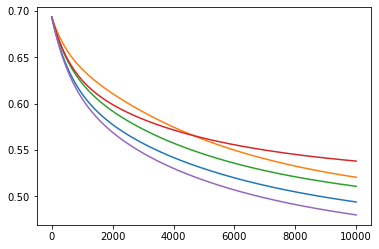

In [12]:
async def run(topology, iterations=100, debug=False):
    dl_data = split_data(X, y, topology)
    consensus_shutdown = asyncio.Queue()
    consensus_network = ConsensusNetwork(topology, consensus_shutdown, debug=debug)
    agents = [ConsensusAgent(token, eps=1e-6, debug=debug) for token in consensus_network.tokens]
    for a in agents:
        consensus_network.register_agent(a)

    async def print_progress():
        from ipywidgets import IntProgress, FloatProgress, FloatText
        from IPython.display import display

        progress = FloatProgress(min=0.0, max=1.0, step=0.01, value=0.0)
        display(progress)
        while True:
            v = list(progress_info.values())
            if len(v) > 0:
                p = np.mean(v)
                progress.value = p
            await asyncio.sleep(0.25)

    progress_task = asyncio.create_task(print_progress())
    tasks = [asyncio.create_task(
                learning_instance(dl_data[a.token][0], dl_data[a.token][1], a, iterations=iterations)
             ) for a in agents]
    best_ws = []
    asyncio.create_task(consensus_network.serve())

    for coro in asyncio.as_completed(tasks):
        best_w, best_err, errors = await coro
        best_ws.append(best_w)
        plt.plot([i for i in range(len(errors))], errors)
    progress_task.cancel()

    for w in best_ws:
        train_predictions = (sigmoid(X @ w) >= 0.5).astype(np.int) * 2 - 1
        print('Score: {}'.format( np.mean( train_predictions == y ) ))

    for w in best_ws:
        print(w)

await run(topology_grid_5, 10000)